<a href="https://colab.research.google.com/github/CharanNara/Data-Structures-and-Algorithms/blob/master/TEAM_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intrusion Detection in Heterogeneous data collection using Machine learning**

# IMPORTING LIBRARIES

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# LOAD DATA

In [ ]:
df = pd.read_csv('network intrusion detection/Train_data.csv')
df_test = pd.read_csv('network intrusion detection/Test_data.csv')
print('Dimensions of training data: ', df.shape)
print('Dimensions of testing data: ', df_test.shape)
type(df)

Dimensions of training data:  (25192, 42)
Dimensions of testing data:  (22544, 41)


pandas.core.frame.DataFrame

In [ ]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print('Train set class distribution')
print(df['class'].value_counts())
print()

Train set class distribution
normal     13449
anomaly    11743
Name: class, dtype: int64



In [ ]:
print(df['num_outbound_cmds'].value_counts())
print(df_test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [ ]:
#Hence, from our observation -> num_outbound_cmds column is a redundant column so remove it from the dataset
df.drop(['num_outbound_cmds'],axis=1,inplace=True)
df_test.drop(['num_outbound_cmds'],axis=1,inplace=True)

# DATA PREPROCESSING

## Scaling Numerical Attributes

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#The below step excludes the columns with string datatype(categorical)
# i.e. extract numerical attributes and scale it to have zero mean and unit variance
cols = df.select_dtypes(include = ['float64','int64']).columns
sc_train = sc.fit_transform(df.select_dtypes(include=['float64','int64']))
sc_test = sc.fit_transform(df_test.select_dtypes(include=['float64','int64']))
sc_train = pd.DataFrame(sc_train,columns=cols)
sc_test = pd.DataFrame(sc_test,columns = cols)

## Encoding Categorical Attributes

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

#Extracting categorical attributes from train and test datasets
categorical_train = df.select_dtypes(include=['object']).copy()
categorical_test = df_test.select_dtypes(include=['object']).copy()

#Encoding categorical attributes
categorical_train = categorical_train.apply(encoder.fit_transform)
categorical_test = categorical_test.apply(encoder.fit_transform)

target_col_train = categorical_train[['class']].copy()
categorical_train = categorical_train.drop(['class'],axis=1)

In [ ]:
train_x = pd.concat([sc_train,categorical_train],axis=1)
train_y = df['class']
train_x.shape

(25192, 40)

In [ ]:
test_df = pd.concat([sc_test,categorical_test],axis=1)
test_df.shape

(22544, 40)

# FEATURE SELECTION

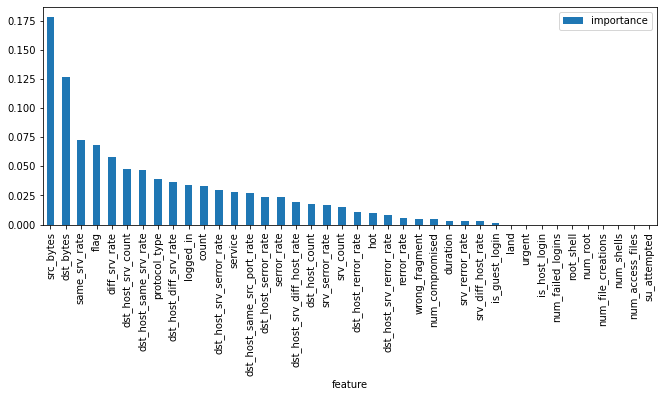

In [ ]:
#Random forests consist of multiple single trees each based on a random sample of the training data. 
#They are typically more accurate than single decision trees. 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
#Fit randomforest on the training set
rfc.fit(train_x,train_y)
#extracting important features
imp = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns, 'importance':imp})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
plt.rcParams['figure.figsize'] = (11,4)
#Plotting graph
importances.plot.bar()

In [ ]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

feature_map = [(i,v) for i,v in itertools.zip_longest(rfe.get_support(),train_x.columns)]
selected_features = [v for i,v in feature_map if i==True]
selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

# DATASET PARTITION

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y,train_size=0.70, random_state=2)

# FITTING MODELS

In [ ]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
dtc_classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
dtc_classifier.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

# EVALUATION OF DECISION TREE MODEL

In [ ]:
from sklearn import metrics
scores = cross_val_score(dtc_classifier,X_train,y_train)
accuracy = metrics.accuracy_score(y_train,dtc_classifier.predict(X_train))
confusion_matrix = metrics.confusion_matrix(y_train,dtc_classifier.predict(X_train))
classification = metrics.classification_report(y_train,dtc_classifier.predict(X_train))
print()
print('============================== {} Model Evaluation =============================='.format('Decision Tree Classifier'))
print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()


============================== Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9950095696419213

Model Accuracy:
 1.0

Confusion matrix:
 [[8245    0]
 [   0 9389]]

Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8245
      normal       1.00      1.00      1.00      9389

    accuracy                           1.00     17634
   macro avg       1.00      1.00      1.00     17634
weighted avg       1.00      1.00      1.00     17634




# VALIDATING DECISION TREE MODEL

In [ ]:
accuracy = metrics.accuracy_score(y_test,dtc_classifier.predict(X_test))
confusion_matrix = metrics.confusion_matrix(y_test,dtc_classifier.predict(X_test))
classification = metrics.classification_report(y_test, dtc_classifier.predict(X_test))
print()
print('============================== {} Model Test Results =============================='.format('Decision Tree Classifier'))
print()
print("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()        


============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9947075946017465

Confusion matrix:
 [[3483   15]
 [  25 4035]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.99      1.00      0.99      3498
      normal       1.00      0.99      1.00      4060

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558




In [ ]:
pred_dtc = dtc_classifier.predict(test_df)
print(pred_dtc)

['anomaly' 'anomaly' 'normal' ... 'anomaly' 'normal' 'anomaly']
